In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay

from mpitree.tree import DecisionTreeClassifier

In [2]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target

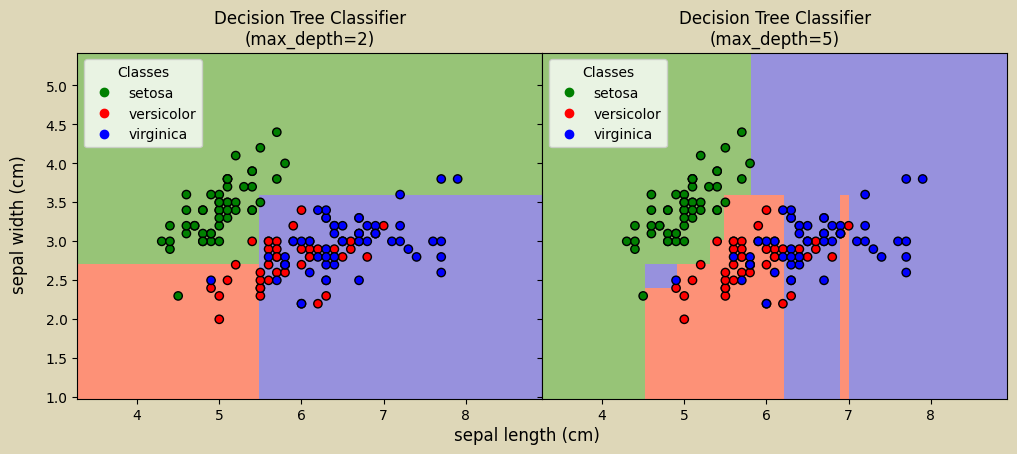

In [3]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(["#97c477", "#fd9177", "#9791dd"])
cmap_bold = ListedColormap(["#008000", "#ff0000", "#0000ff"])

fig, axs = plt.subplots(
    ncols=2,
    sharex="col",
    sharey="row",
    figsize=(12, 4.5),
    facecolor="#ded7b7fb",
    gridspec_kw={"wspace": 0, "hspace": 0},
)

for ax, depth in zip(axs, (2, 5)):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        ax=ax,
        cmap=cmap_light,
    )
    scatter = disp.ax_.scatter(X[:, 0], X[:, 1], cmap=cmap_bold, c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="upper left",
        title="Classes",
    )
    _ = disp.ax_.set_title(f"Decision Tree Classifier\n(max_depth={depth})")

fig.supxlabel("sepal length (cm)")
fig.supylabel("sepal width (cm)", x=0.069)

plt.show()

In [4]:
DecisionTreeClassifier().fit(X, y)

DecisionTreeClassifier()

In [5]:
import numpy as np
import time


def gen_uniform_points(n_samples, step=10):
    x_coor = range(1, n_samples, step)
    y_coor = []

    for x in x_coor:
        X = np.array([[i] for i in range(x)])
        y = np.arange(len(X))

        start = time.time()
        DecisionTreeClassifier().fit(X, y)
        end = time.time()

        y_coor.append((end - start) * 1000)

    return x_coor, y_coor

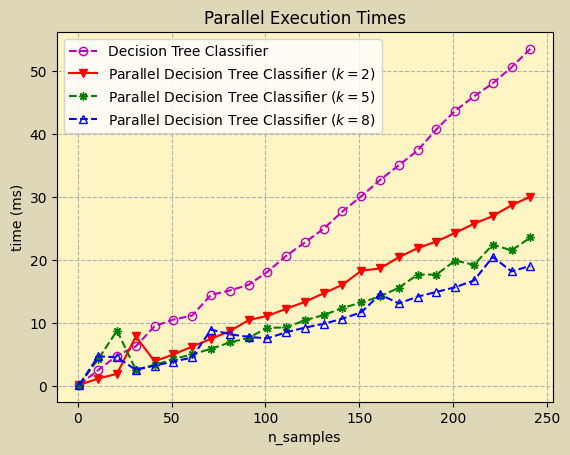

In [6]:
fig = plt.figure(facecolor="#ded7b7fb")
ax = fig.add_subplot()

x_coor, y_coor = gen_uniform_points(250)
ax.plot(
    x_coor,
    y_coor,
    c="m",
    marker="o",
    ls="--",
    label="Decision Tree Classifier",
    fillstyle="none",
)

k_2 = [
    0.17,
    1.15,
    1.92,
    7.83,
    3.89,
    4.99,
    6.23,
    7.46,
    8.68,
    10.42,
    11.1,
    12.22,
    13.32,
    14.69,
    16.03,
    18.26,
    18.62,
    20.41,
    21.85,
    22.9,
    24.27,
    25.72,
    26.93,
    28.66,
    30.01,
]
ax.plot(
    x_coor,
    k_2,
    c="r",
    marker="v",
    ls="-",
    label="Parallel Decision Tree Classifier $(k=2)$",
)

k_5 = [
    0.17,
    4.26,
    8.75,
    2.56,
    3.31,
    4.25,
    5.0,
    5.87,
    6.88,
    7.61,
    9.22,
    9.26,
    10.4,
    11.24,
    12.33,
    13.23,
    14.19,
    15.56,
    17.65,
    17.65,
    19.88,
    19.2,
    22.41,
    21.48,
    23.54,
]
ax.plot(
    x_coor,
    k_5,
    c="g",
    marker=(8, 2, 0),
    ls="--",
    label="Parallel Decision Tree Classifier $(k=5)$",
)

k_8 = [
    0.19,
    4.7,
    4.52,
    2.54,
    3.22,
    3.84,
    4.51,
    8.92,
    8.19,
    7.76,
    7.54,
    8.49,
    9.24,
    9.84,
    10.66,
    11.67,
    14.5,
    13.07,
    14.16,
    14.9,
    15.64,
    16.72,
    20.45,
    18.16,
    19.02,
]
ax.plot(
    x_coor,
    k_8,
    c="b",
    marker="^",
    ls="--",
    label="Parallel Decision Tree Classifier $(k=8)$",
    fillstyle="none",
)

ax.set_facecolor("#fff4c4")
ax.set_xlabel("n_samples")
ax.set_ylabel("time (ms)")

plt.title("Parallel Execution Times")
plt.legend(loc=2)
plt.grid(ls="--")
plt.show()